# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [2]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,13.637821,0.131756,0.092638,0.03691,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000,0.147600,0.000000,0.00000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000000,0.167798,0.088409,0.00000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [4]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
jan_prices.drop(['price_date'],inplace=True,axis=1)
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices, on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


### Sorting out correlations between price fluctuation variables

We start the feature engineering work from reducing the dimension of 27 price columns. By examining the correlation of all kinds of price item, we find: 

- p2(peak_price) and p3(mid_price) are always highly correlated with one another, regardless of if it is the mean of 3-month, 6-month or the whole year, or if it is variate or fixed price. So we remove all p2 or p3 in one analysis, keep only one of them with p1.

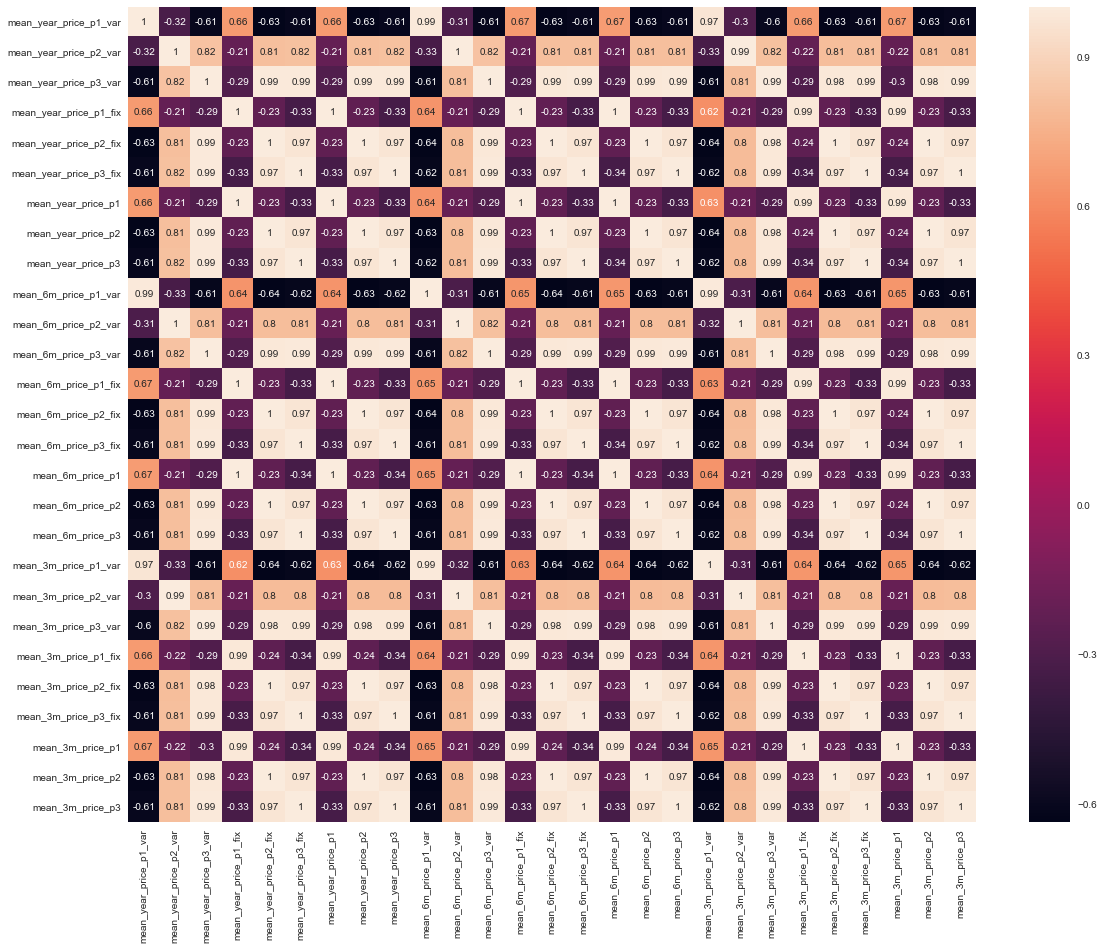

In [6]:
correlation1 = df.loc[:,list(df.columns)[list(df.columns).index("mean_year_price_p1_var"):]].corr()

plt.figure(figsize=(19,15))
sns.heatmap(correlation1, xticklabels=correlation1.columns.values,
            yticklabels=correlation1.columns.values, annot = True, annot_kws={'size':10})

- The correlations between p1(off_peak_price) fixed or p1 variate prices are high, regardless of 3-month mean, 6-month mean or whole year. p1 fixed/fixed+variate price and p1 variate price don't related much to each other. Therefore, only one one set of price, either p1 fix+var price and p1 var price, or p1 fix price and p1 var price will be used in one analysis. Also, only one of 3-month mean, 6-month mean or whole year mean will be used in one analysis.

- To sum up, in one analysis, we'll use one p1 fix price, one p1 var price and one p2/p3 var+fix price from one of 3-month, 6-month, whole year mean groups. e.g. `mean_year_price_p1_var`, `mean_year_price_p1_fix` and `mean_year_price_p2` could be one price group used in one analysis; `mean_6m_price_p1_var`, `mean_6m_price_p1_fix` and `mean_6m_price_p3` could also be one price group in one analysis.

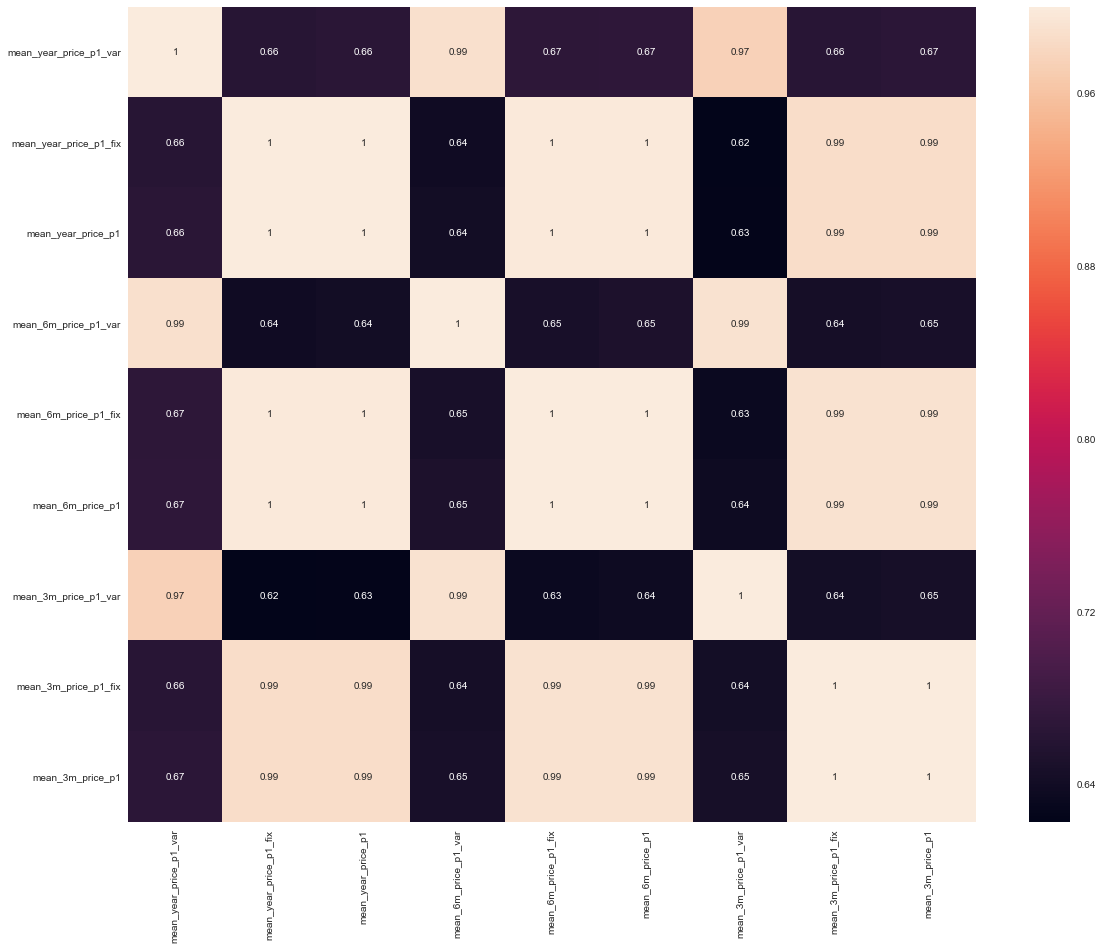

In [7]:
p1_name = ["mean_year_price_p1_var","mean_year_price_p1_fix","mean_year_price_p1",
          "mean_6m_price_p1_var","mean_6m_price_p1_fix","mean_6m_price_p1",
          "mean_3m_price_p1_var","mean_3m_price_p1_fix","mean_3m_price_p1"]
correlation2 = df.loc[:,p1_name].corr()
plt.figure(figsize=(19,15))
sns.heatmap(correlation2, xticklabels=correlation2.columns.values,
            yticklabels=correlation2.columns.values, annot = True, annot_kws={'size':10})

### Turning categorical data into dummy variables

In `df` which contains cleaned data, we should turn categorical variables into dummy variables. This transformation should happen to `origin_up` and `channel_sales`.

- `channel_sales`: This variable only has 8 different values, so we will create 7 dummy variables.

In [8]:
df["channel_sales"] = df["channel_sales"].astype("category")
pd.DataFrame({"Samples in category": df["channel_sales"].value_counts()})

,Samples in category
foosdfpfkusacimwkcsosbicdxkicaua,6753
MISSING,3725
lmkebamcaaclubfxadlmueccxoimlema,1843
usilxuppasemubllopkaafesmlibmsdf,1375
ewpakwlliwisiwduibdlfmalxowmwpci,893
sddiedcslfslkckwlfkdpoeeailfpeds,11
epumfxlbckeskwekxbiuasklxalciiuu,3
fixdbufsefwooaasfcxdxadsiekoceaa,2


In [9]:
categories_channel = pd.get_dummies(df["channel_sales"], prefix = "channel")
# Rename columns for simplicity
categories_channel.columns = [col_name[:11] for col_name in categories_channel.columns]
# Make missing values the vector full of 0 for the channel variable 
categories_channel.drop(["channel_MIS"],inplace=True,axis=1)
categories_channel.head()

,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0


- `origin_up`: This variable only has 6 different values, so we will create 5 dummy variables.

In [10]:
df["origin_up"] = df["origin_up"].astype("category")
pd.DataFrame({"Samples in category": df["origin_up"].value_counts()})

,Samples in category
lxidpiddsbxsbosboudacockeimpuepw,7096
kamkkxfxxuwbdslkwifmmcsiusiuosws,4294
ldkssxwpmemidmecebumciepifcamkci,3148
MISSING,64
usapbepcfoloekilkwsdiboslwaxobdp,2
ewxeelcelemmiwuafmddpobolfuxioce,1


In [11]:
categories_origin = pd.get_dummies(df["origin_up"], prefix = "origin")
# Rename columns for simplicity
categories_origin.columns = [col_name[:11] for col_name in categories_origin.columns]
# Make missing values the vector full of 0 for the origin variable 
categories_origin.drop(["origin_MISS"],inplace=True,axis=1)
categories_origin.head()

,origin_ewxe,origin_kamk,origin_ldks,origin_lxid,origin_usap
0,0,0,0,1,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


- `has_gas`: This is a bool variable, we can simply turn T into 1 and F into 0.

In [12]:
df["has_gas"]=df["has_gas"].replace(["t", "f"],[1,0])

# Combine the 2 new categories_df to the original df to get our updated dataset for analysis
df = pd.merge(df, categories_channel, left_index=True, right_index=True)
df = pd.merge(df, categories_origin, left_index=True, right_index=True)
df.drop(["channel_sales", "origin_up"],inplace=True,axis=1)
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewxe,origin_kamk,origin_ldks,origin_lxid,origin_usap
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0,1,0,0,0,0,0,0,1,0
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0,0,0,0,0,0,1,0,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0,1,0,0,0,0,1,0,0,0
3,3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0,0,1,0,0,0,1,0,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0,0,0,0,0,0,1,0,0,0


### Translate time point into variables that describe clients' behaviors and psychology

We have 4 time point varibales: `date_activ`, `date_end`, `date_modif_prod`, `date_renewal`. By calculating the timediff of different combinations, we could several new variables that contains different meanings.

- `months_activ`: Number of months active until reference date (Jan 2016)
- `months_to_end`: Number of months of the contract left at reference date (Jan 2016)
- `months_modif_prod`: Number of months since last modification at reference date (Jan 2016)
- `months_renewal`: Number of months since last renewal at reference date (Jan 2016)

In [13]:
basic_day = datetime(2016,1,1)
df.insert(len(df.columns),"months_activ",0)
df.insert(len(df.columns),"months_to_end",0)
df.insert(len(df.columns),"months_modif_prod",0)
df.insert(len(df.columns),"months_renewal",0)
for index,row in df.iterrows():
    row["months_activ"] = np.round((basic_day - row["date_activ"]).days/30)
#     print(row["months_activ"])
    row["months_to_end"] = np.round((row["date_end"] - basic_day).days/30)
    row["months_modif_prod"] = np.round((basic_day - row["date_modif_prod"]).days/30)
    row["months_renewal"] = np.round((basic_day - row["date_renewal"]).days/30)
    df.iloc[index] = row
    
df[["months_activ","months_to_end","months_modif_prod","months_renewal"]].describe()

,months_activ,months_to_end,months_modif_prod,months_renewal
count,14605.000000,14605.000000,14605.000000,14605.000000
mean,59.963643,6.944197,36.433208,5.444231
std,19.654315,3.587708,30.775762,3.962573
min,16.000000,1.000000,-1.000000,-1.000000
25%,45.000000,4.000000,7.000000,2.000000
50%,59.000000,7.000000,31.000000,5.000000
75%,73.000000,10.000000,66.000000,9.000000
max,154.000000,18.000000,154.000000,31.000000


See what insight we can draw from the new days variables. Define the distribution visualization function at first.

In [14]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

Define the function to calculate the churn rates in several customer groups

In [15]:
def churn_rate_by_group(df,column,n):
    min_v = min(df[column])
    max_v = max(df[column])
    diff = (max_v-min_v)/n
    data = {}
    for index,row in df.iterrows():
        a = np.floor((row[column]-min_v)/diff)
        if a not in data.keys():
            data[a] = [index]
        else:
            data[a].append(index)
    c = []
    for i in range(len(data)):
        if i in data.keys():
            avg = df["churn"][data[i]].mean()
            c.append([i,(min_v+i*diff,min_v+(i+1)*diff),len(data[i]),avg])
    new_df = pd.DataFrame(data=c,columns=["group id","value range","num of clients","churn rate"])
    return new_df

> For `months_activ` which kind of describes clients loyalty to PowerCo, the longer the client stays with PowerCo, the loyaler it may be. The max value of `months_activ` is 159 months, while the min is 16. We divide the variable into 10 groups, we can see that older clients seem more unlikely to churn than new clients.

    group id     value range  num of clients  churn rate
0          0    (16.0, 29.8)              12    0.250000
1          1    (29.8, 43.6)            3056    0.135144
2          2    (43.6, 57.4)            4079    0.109586
3          3    (57.4, 71.2)            3215    0.074650
4          4    (71.2, 85.0)            3611    0.076987
5          5    (85.0, 98.8)             139    0.057554
6          6   (98.8, 112.6)             103    0.019417
7          7  (112.6, 126.4)              77    0.051948
8          8  (126.4, 140.2)             216    0.078704
9          9  (140.2, 154.0)              96    0.072917
10        10  (154.0, 167.8)               1    0.000000


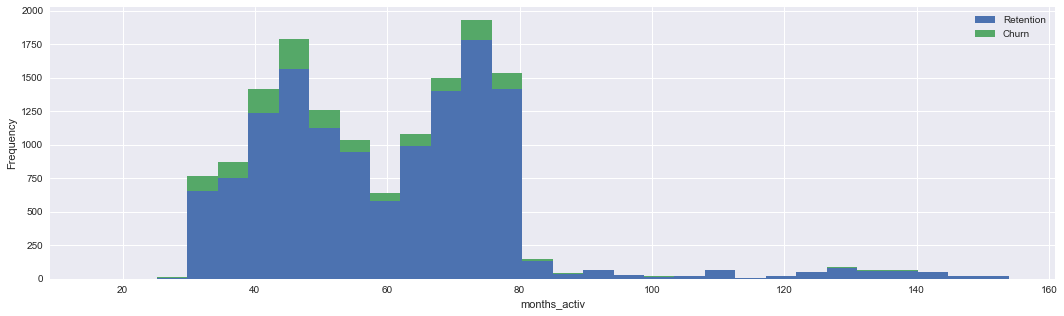

In [16]:
print(churn_rate_by_group(df,"months_activ",10))
fig, axs = plt.subplots(nrows=1, figsize=(18, 5))
plot_distribution(df, "months_activ", axs, bins_=30)

> `months_to_end` is supposed to describe the 'cost' to churn: theoretically, when the service end day is closer, client will be more unlikely to churn because their service will automatically end anyway, so why borther changing electricity supllier now. But from the churn rate results across different groups with far or close to the end day, this variable doesn't seem to have much impact. So we are not going to use it in our final model. 

   group id   value range  num of clients  churn rate
0         0    (1.0, 4.4)            4321    0.102523
1         1    (4.4, 7.8)            3564    0.093434
2         2   (7.8, 11.2)            4917    0.096197
3         3  (11.2, 14.6)            1800    0.094444
4         4  (14.6, 18.0)               1    0.000000
5         5  (18.0, 21.4)               2    0.000000


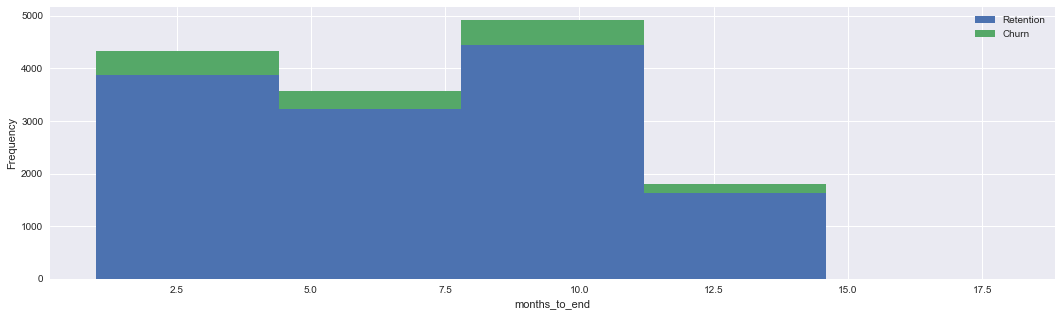

In [17]:
print(churn_rate_by_group(df,"months_to_end",5))
fig, axs = plt.subplots(nrows=1, figsize=(18, 5))
plot_distribution(df, "months_to_end", axs, bins_=5)

> Clients' willingness to stay with PowerCo is supposed to decrease as the value of `months_modif_prod` gets smaller, because a modification in the subsciption means a interaction between PowerCo and the client, and clients may take deep consideration on whether to churn or to modify the subscription instead. However, the result may seem inconsitent with the theory, but it inluence churn rate, so `month_modif_prod` should be in the final model.

    group id      value range  num of clients  churn rate
0          0     (-1.0, 6.75)            3471    0.103140
1          1     (6.75, 14.5)            1811    0.110436
2          2    (14.5, 22.25)            1142    0.110333
3          3    (22.25, 30.0)             812    0.133005
4          4    (30.0, 37.75)             608    0.128289
5          5    (37.75, 45.5)             870    0.121839
6          6    (45.5, 53.25)             996    0.105422
7          7    (53.25, 61.0)             730    0.067123
8          8    (61.0, 68.75)            1183    0.059172
9          9    (68.75, 76.5)            1808    0.075221
10        10    (76.5, 84.25)             789    0.077313
11        11    (84.25, 92.0)              66    0.060606
12        12    (92.0, 99.75)              22    0.090909
13        13   (99.75, 107.5)              28    0.000000
14        14  (107.5, 115.25)              54    0.018519
15        15  (115.25, 123.0)              20    0.150000
16        16  

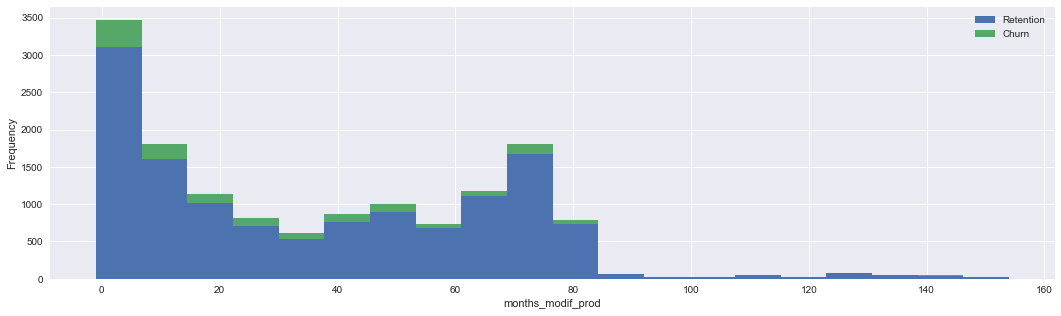

In [18]:
print(churn_rate_by_group(df,"months_modif_prod",20))
fig, axs = plt.subplots(nrows=1, figsize=(18, 5))
plot_distribution(df, "months_modif_prod", axs, bins_=20)

> Similar to `months_modif_prod`, the smaller the value of `months_renewal`, the higher the willingness to stay. It's not obvious in our dataset, though. Keep the variable for further observation.

    group id   value range  num of clients  churn rate
0          0   (-1.0, 0.6)            1498    0.099466
1          1    (0.6, 2.2)            2672    0.094311
2          2    (2.2, 3.8)            1041    0.097983
3          3    (3.8, 5.4)            2185    0.088330
4          4    (5.4, 7.0)            1651    0.092065
5          5    (7.0, 8.6)            1849    0.101677
6          6   (8.6, 10.2)            2389    0.105483
7          7  (10.2, 11.8)             976    0.103484
8          8  (11.8, 13.4)             150    0.073333
9          9  (13.4, 15.0)               6    0.000000
10        10  (15.0, 16.6)              48    0.166667
11        11  (16.6, 18.2)              60    0.100000
12        12  (18.2, 19.8)              15    0.200000
13        13  (19.8, 21.4)              21    0.000000
14        14  (21.4, 23.0)               8    0.125000
15        15  (23.0, 24.6)              11    0.000000
16        16  (24.6, 26.2)               9    0.111111
17        

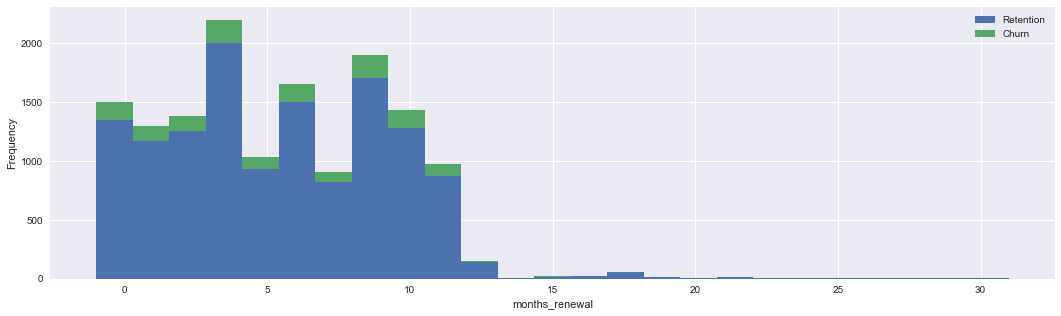

In [19]:
print(churn_rate_by_group(df,"months_renewal",20))
fig, axs = plt.subplots(nrows=1, figsize=(18, 5))
plot_distribution(df, "months_renewal", axs, bins_=25)

### Transfornmation of other attributes in the dataset

The distribution of variables including `cons_12m`, `cons_last_month`, `forecast_cons_12m`, `forecast_cons_year`, `forecast_meter_rent_12m` and `imp_cons` are skewed, we can use log transformation to fix that.

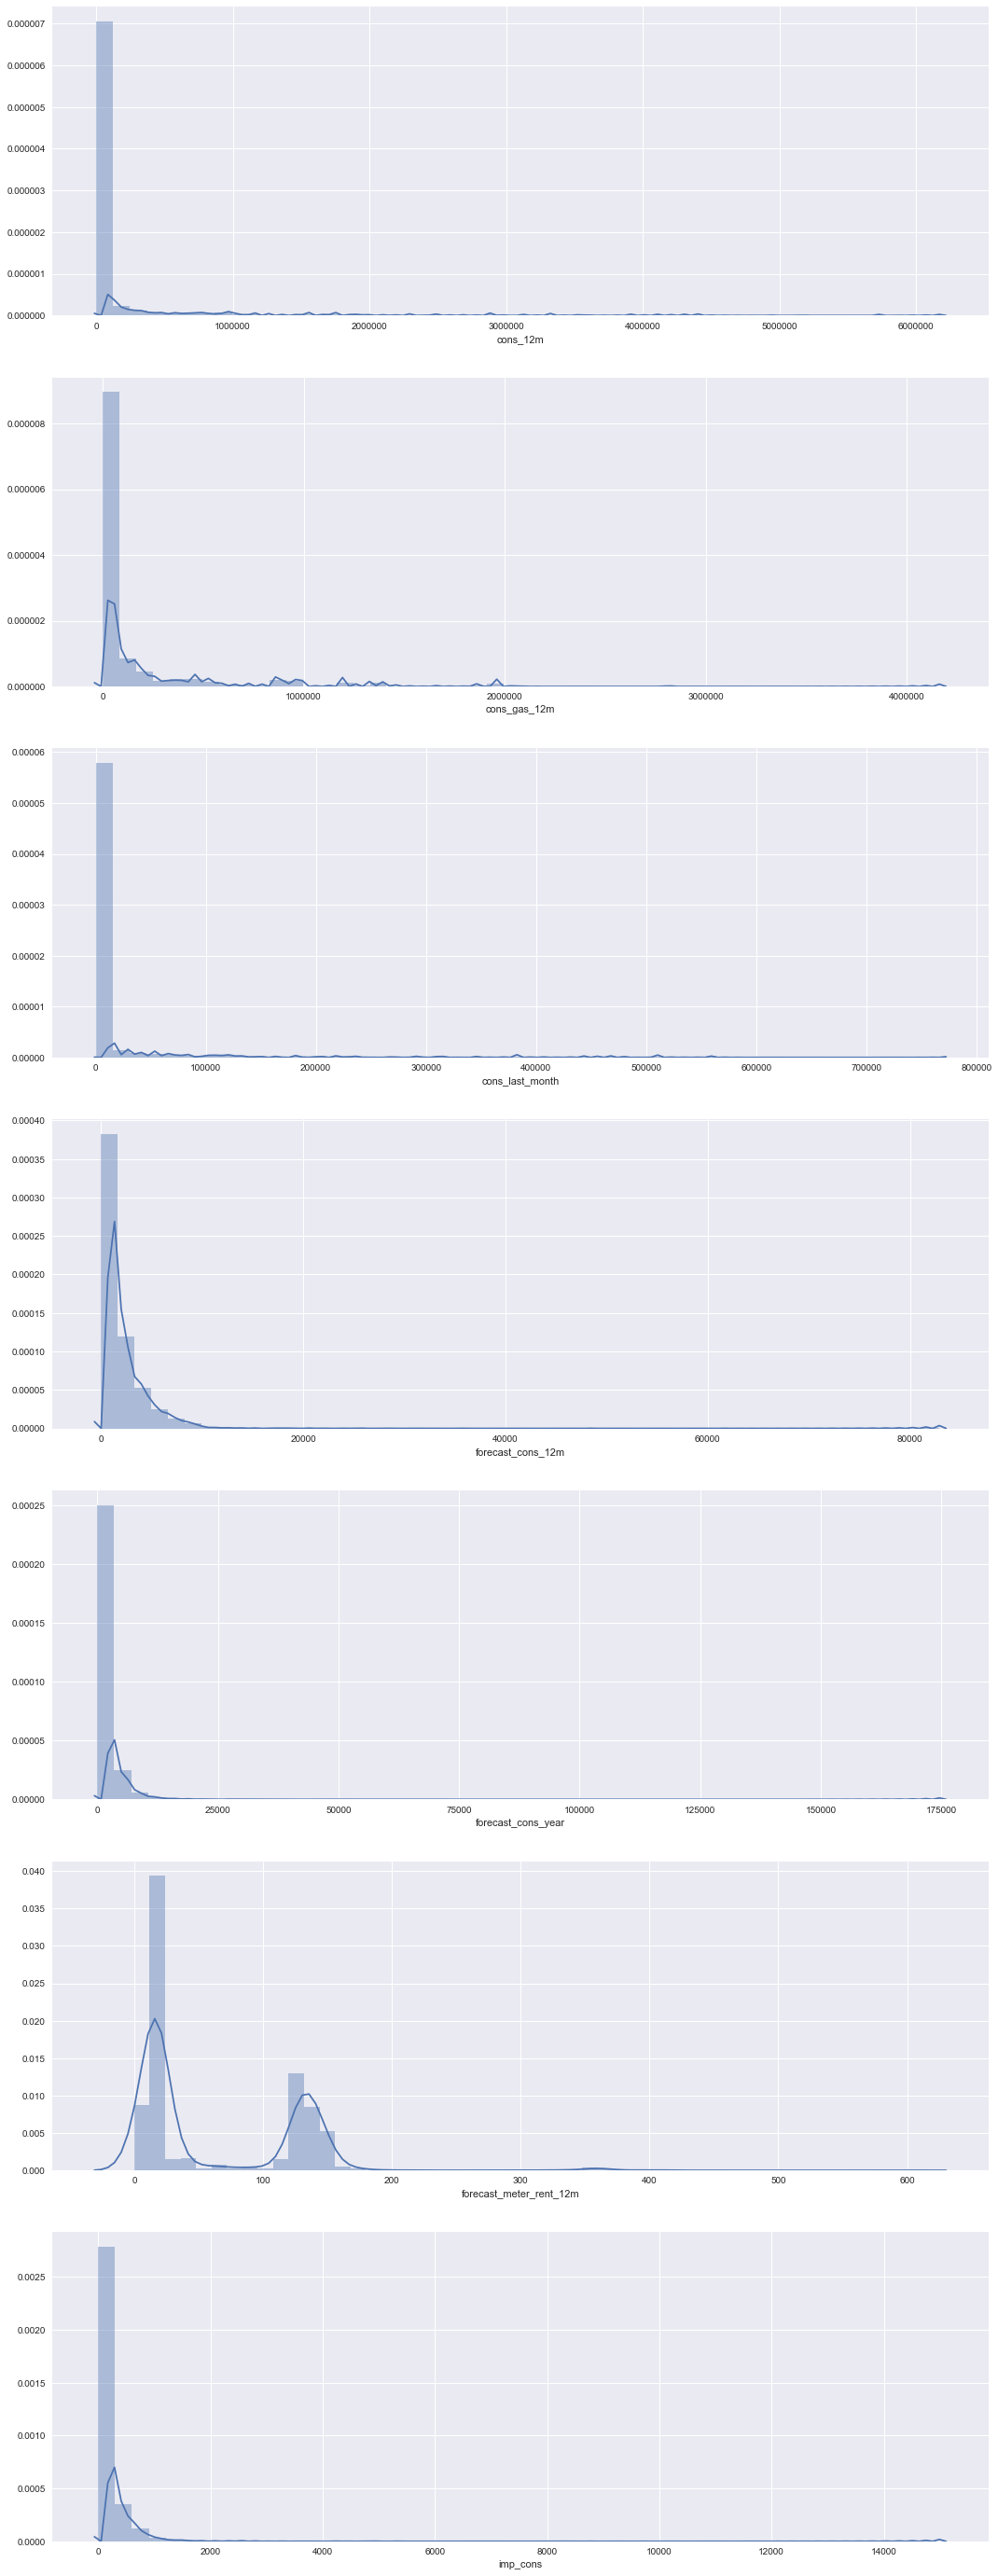

In [20]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
sns.distplot((df["forecast_cons_12m"].dropna()), ax=axs[3])
sns.distplot((df["forecast_cons_year"].dropna()), ax=axs[4])
sns.distplot((df["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.distplot((df["imp_cons"].dropna()), ax=axs[6])
plt.show()

In [21]:
# Remove negative values
df.loc[df.cons_12m < 0,"cons_12m"] = np.nan
df.loc[df.cons_gas_12m < 0,"cons_gas_12m"] = np.nan
df.loc[df.cons_last_month < 0,"cons_last_month"] = np.nan
df.loc[df.forecast_cons_12m < 0,"forecast_cons_12m"] = np.nan
df.loc[df.forecast_cons_year < 0,"forecast_cons_year"] = np.nan
df.loc[df.forecast_meter_rent_12m < 0,"forecast_meter_rent_12m"] = np.nan
df.loc[df.imp_cons < 0,"imp_cons"] = np.nan

df["cons_12m"] = np.log10(df["cons_12m"]+1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"]+1)
df["cons_last_month"] = np.log10(df["cons_last_month"]+1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"]+1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"]+1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"]+1)
df["imp_cons"] = np.log10(df["imp_cons"]+1)

Add 1 to all the variable values to avoid negative transformarion log value.

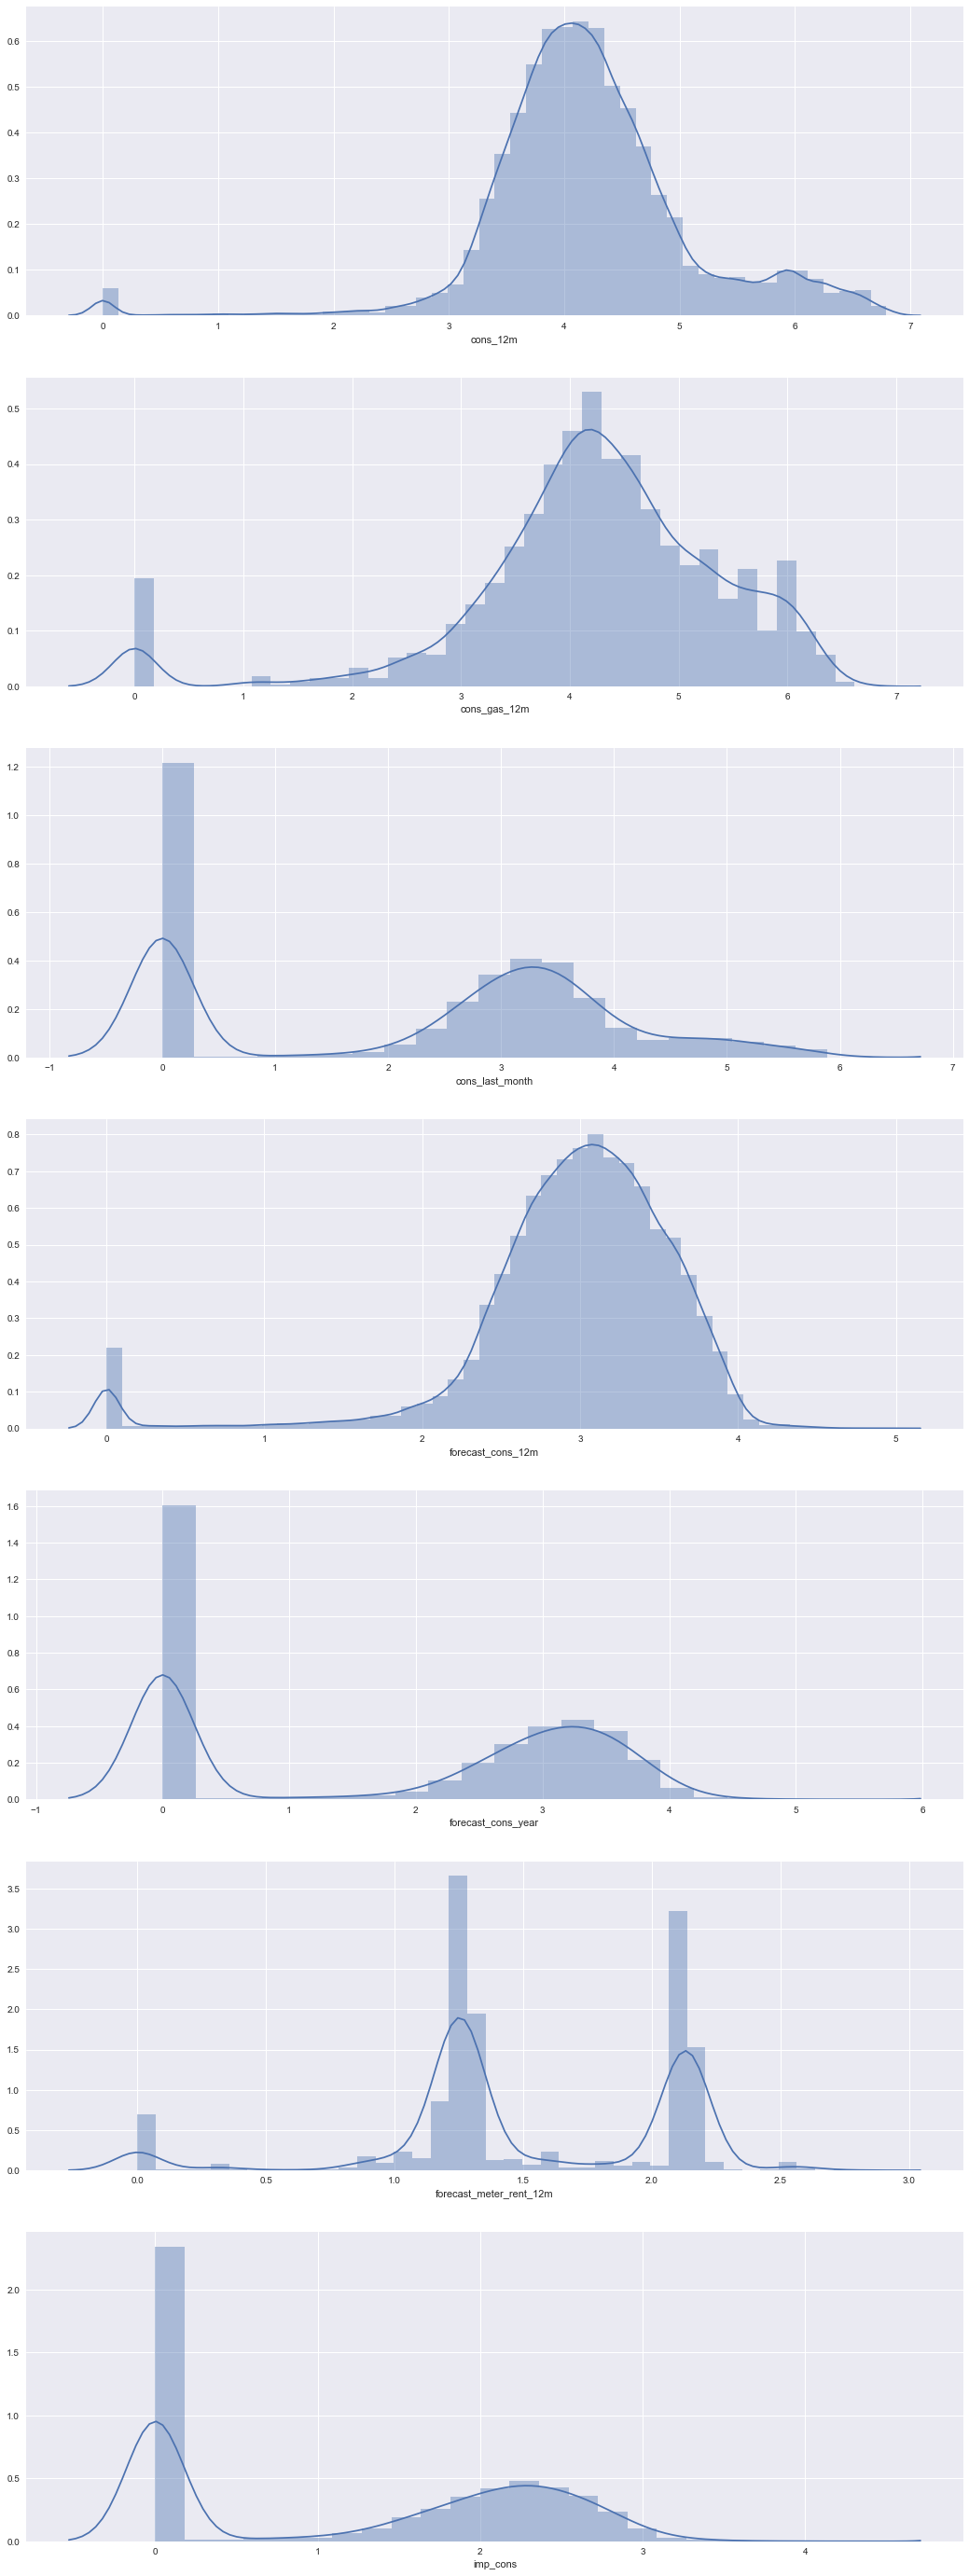

In [22]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
sns.distplot((df["forecast_cons_12m"].dropna()), ax=axs[3])
sns.distplot((df["forecast_cons_year"].dropna()), ax=axs[4])
sns.distplot((df["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.distplot((df["imp_cons"].dropna()), ax=axs[6])
plt.show()

### Preparing the data for the final model

Delete 
- `months_to_end`
- Variables associated with mean_price
See the correlation table and further continue to delete:

- `has_gas`
- `forecast_price_energy_off_peak`, `forecast_price_energy_peak`, `forecast_price_pow_off_peak`: So correlated to the three historical prices.
- `margin_gross_pow_ele`: So correlated to `margin_net_pow_ele`
- `months_activ`: equivalent as `num_years_antig`
- `imp_cons`: Correlated with many columns

Remember that the datetime objects are still in the dataframe, delete them at the same time.

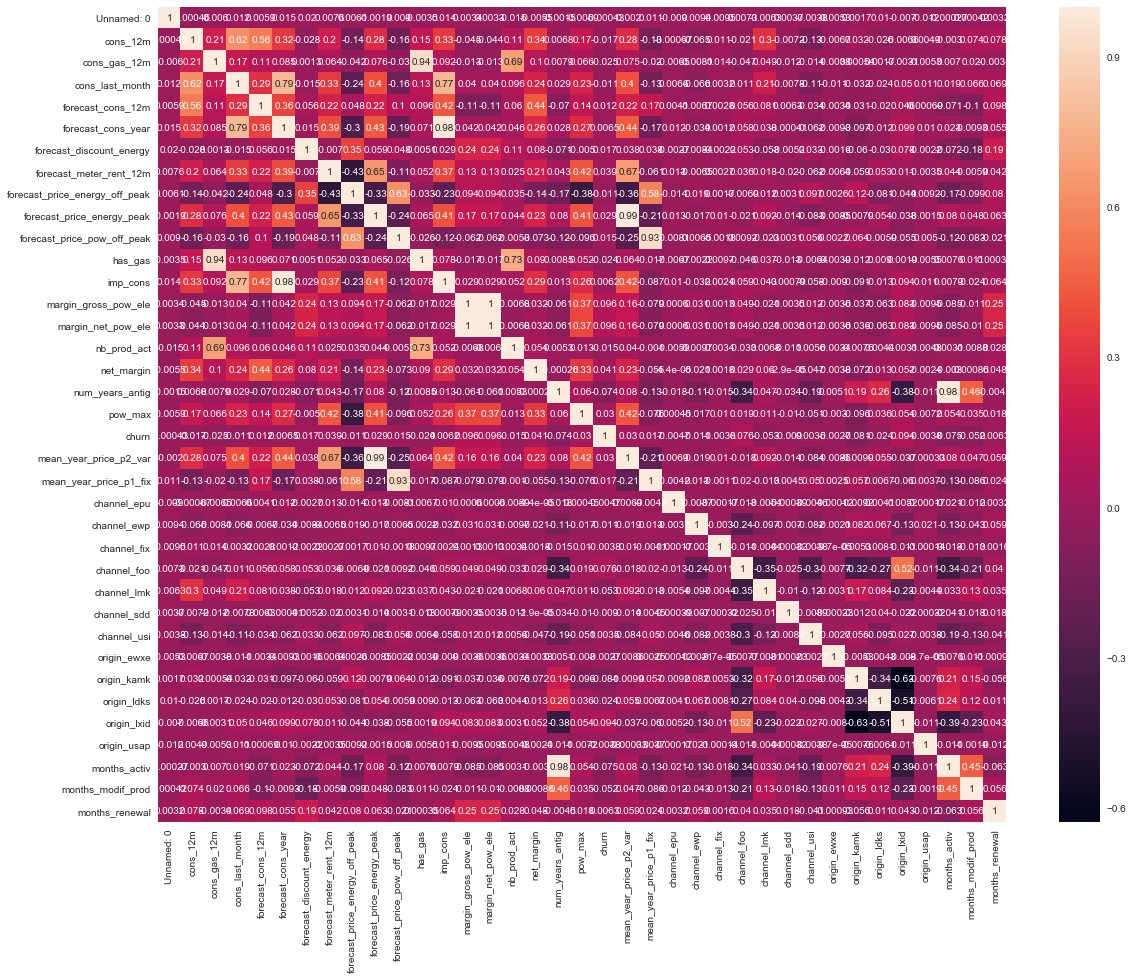

In [23]:
# Combined all the variables together, look at their correlations
df.drop(["months_to_end","mean_year_price_p1","mean_year_price_p1_var",
          "mean_6m_price_p1_var","mean_6m_price_p1_fix","mean_6m_price_p1",
          "mean_3m_price_p1_var","mean_3m_price_p1_fix","mean_3m_price_p1",
        "mean_year_price_p2_fix","mean_year_price_p2",
          "mean_6m_price_p2_var","mean_6m_price_p2_fix","mean_6m_price_p2",
          "mean_3m_price_p2_var","mean_3m_price_p2_fix","mean_3m_price_p2",
        "mean_year_price_p3_var","mean_year_price_p3_fix","mean_year_price_p3",
          "mean_6m_price_p3_var","mean_6m_price_p3_fix","mean_6m_price_p3",
          "mean_3m_price_p3_var","mean_3m_price_p3_fix","mean_3m_price_p3"],inplace=True,axis=1)

correlation3 = df.corr()
plt.figure(figsize=(19,15))
sns.heatmap(correlation3, xticklabels=correlation3.columns.values,
            yticklabels=correlation3.columns.values, annot = True, annot_kws={'size':10})

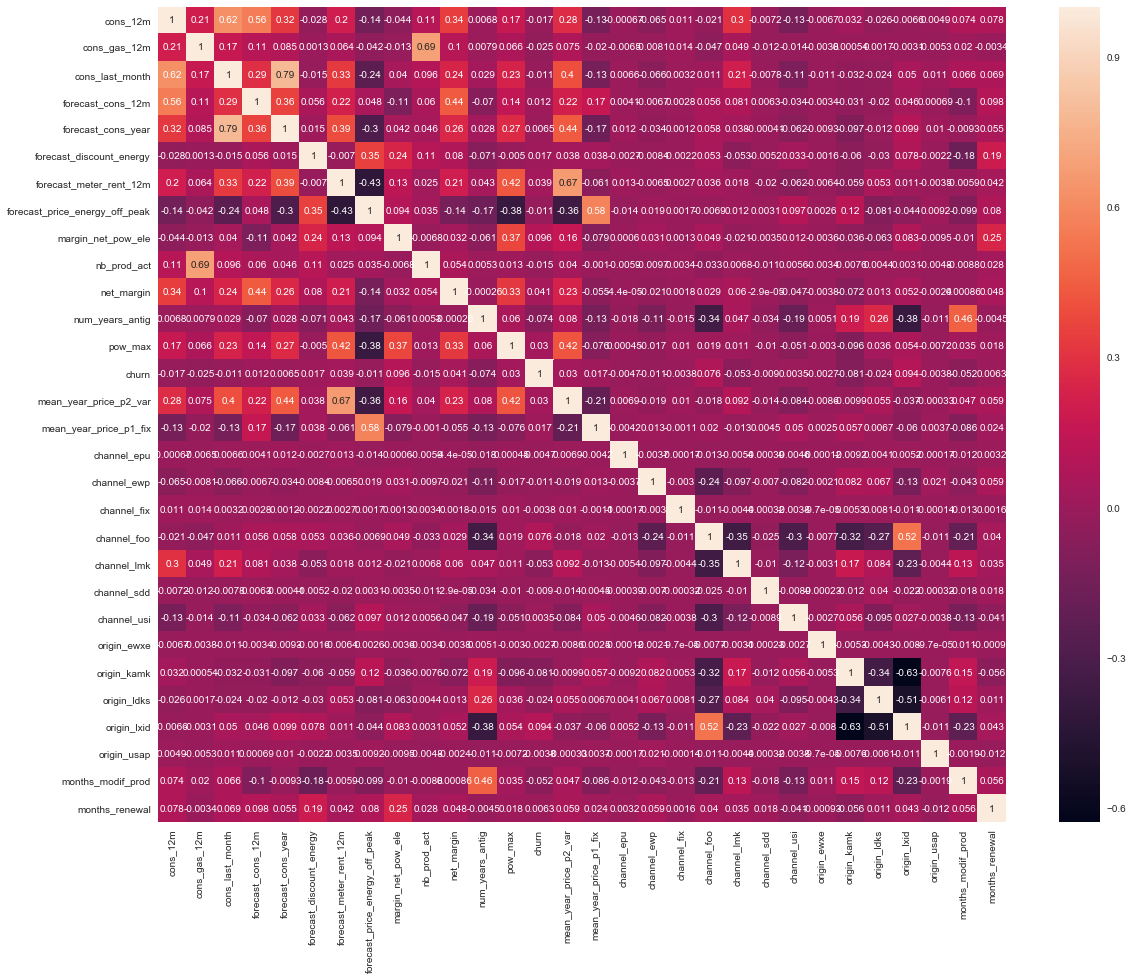

In [24]:
df.drop(["Unnamed: 0","has_gas","imp_cons","forecast_price_energy_peak",
         "forecast_price_pow_off_peak","margin_gross_pow_ele","months_activ",
         "date_activ","date_end","date_modif_prod","date_renewal"],inplace=True,axis=1)
correlation4 = df.corr()
plt.figure(figsize=(19,15))
sns.heatmap(correlation4, xticklabels=correlation4.columns.values,
            yticklabels=correlation4.columns.values, annot = True, annot_kws={'size':10})

---

## 4. Random Forest Model

### Model Explanation

For a binary-classification random forest model, the accuracy must be the most important evaluation metrics, as to calculate how many clients are classified correctly. An over 0.9 test accuracy rate indicates a good performance of the model. However, the test R square is much lower than train R square.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn import metrics

churn_index = list(df.columns).index("churn")
id_index = list(df.columns).index("id")
X_list = [i for i in range(len(df.columns)) if i != churn_index and i != id_index]
X = df.iloc[:,X_list]
y = df["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print("Train/Test Split Result")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
forest = RandomForestClassifier(n_estimators=1000)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('Accuracy train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))

Train/Test Split Result
(10223, 29)
(10223,)
(4382, 29)
(4382,)
Accuracy train: 1.000, test: 0.905


Aside from accuracy, recall and precision is equally important for this task. Precision means the fraction of truly churned customers of all the customers classified to be chunred by the model, while recall means the fraction of truly churned customers selected by the model to all churned customers. The model achieves a high precision but a low recall, which means most of the customers who are predicted to be churn has a high rate of ending up churning, but we'll miss a many churned customers - we can't find them until they churn. 

In [26]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_test_pred).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Precision: {metrics.precision_score(y_test, y_test_pred)}")
print(f"Recall: {metrics.recall_score(y_test, y_test_pred)}")

True positives: 15
False positives: 3
True negatives: 3951
False negatives: 413

Precision: 0.8333333333333334
Recall: 0.035046728971962614


We can use feature importance to interprete features that have relatively high impact on the model. The variables with high importances are:

|Variable|Importance|Definition|Explanation|
|---|---|---|---|
|`margin_net_pow_ele`|0.91|net margin on power subscription|Customers will consider the margin cost they pay PowerCo to decide whether to churn or not|
|`cons_12m`|0.88|electricity consumption of the past 12 months|Show how much the client depend on PowerCo's electricity supply|
|`net_margin`|0.85|total net margin||
|`forecast_meter_rent_12m`|0.84|forecasted bill of meter rental for the next 2 months|Reflect client's peripheral usage of PowerCo's product|
|`forecast_cons_12m`|0.81|forecasted electricity consumption for next 12 months|Reflect whether the client is a heavy electricity consumer|
|`mean_year_price_p1_var`|0.77|average variate fee charged per degree of electricity|Price sensitivity matters|

[('cons_12m', 0.090999999999999998), ('margin_net_pow_ele', 0.090999999999999998), ('net_margin', 0.085999999999999993), ('forecast_meter_rent_12m', 0.085000000000000006), ('forecast_cons_12m', 0.082000000000000003), ('cons_last_month', 0.063), ('months_modif_prod', 0.063), ('pow_max', 0.062), ('forecast_price_energy_off_peak', 0.059999999999999998), ('mean_year_price_p1_fix', 0.055), ('forecast_cons_year', 0.053999999999999999), ('months_renewal', 0.049000000000000002), ('mean_year_price_p2_var', 0.048000000000000001), ('num_years_antig', 0.027), ('cons_gas_12m', 0.021000000000000001), ('nb_prod_act', 0.014), ('channel_foo', 0.01), ('origin_lxid', 0.0080000000000000002), ('channel_usi', 0.0060000000000000001), ('origin_kamk', 0.0060000000000000001), ('origin_ldks', 0.0060000000000000001), ('channel_lmk', 0.0050000000000000001), ('forecast_discount_energy', 0.0040000000000000001), ('channel_ewp', 0.0040000000000000001), ('channel_epu', 0.0), ('channel_fix', 0.0), ('channel_sdd', 0.0), 

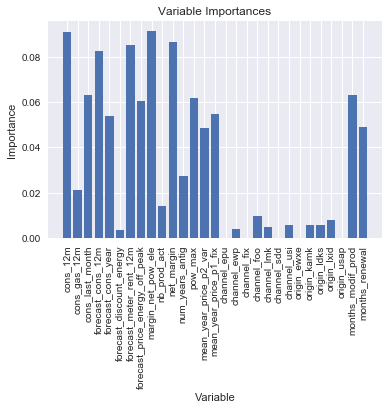

In [27]:
importances = list(forest.feature_importances_)
feature_list = list(df.columns[X_list])

feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
print(feature_importances)

x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list,rotation=90)
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.show()

Select all the variables with feature importance higher than 0.05, and train another regression tree model. We can see that there's no big change in accuracy, but the recall and precision both go down in a large scale, so we continue to use the model with more predictors above.

In [28]:
important_feature = [name[0] for name in feature_importances if name[1]>0.05]
X_i = df[important_feature].values
y_i = df["churn"].values
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_i, y_i, test_size=0.7, random_state=1)
forest1 = RandomForestClassifier(n_estimators=1000)
forest1.fit(X_train, y_train)
y_train_pred1 = forest1.predict(X_train)
y_test_pred1 = forest1.predict(X_test)

print('Accuracy train: %.3f, test: %.3f \n' % (
        accuracy_score(y_train, y_train_pred1),
        accuracy_score(y_test, y_test_pred1)))

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_test_pred1).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Precision: {metrics.precision_score(y_test, y_test_pred1)}")
print(f"Recall: {metrics.recall_score(y_test, y_test_pred1)}")

Accuracy train: 1.000, test: 0.905 

True positives: 15
False positives: 2
True negatives: 3952
False negatives: 413

Precision: 0.8823529411764706
Recall: 0.035046728971962614


In [29]:
proba_predictions = forest.predict_proba(X_test)
probabilities = proba_predictions[:, 1]
X_test = X_test.reset_index()
X_test.drop(['index'], inplace=True,axis=1)
X_test['churn'] = y_test_pred.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('sample_data_with_predictions.csv')